# 275 Bird Species also see 73 Sports Dataset

今までのPyTorchの学習を活かして、実際にデータを分類してみる。

今回用いるデータは、Kaggleに上がっていた、２７５種類の鳥の分類問題である。

詳細は、https://www.kaggle.com/gpiosenka/100-bird-species

## ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

## デバイスの確認

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## データの前処理

7/1

過学習対策として、データ拡張を行う。

そのために、トレーニングデータとテストデータ別々のtransformを作成する。

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [4]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [5]:
train_dataset = datasets.ImageFolder('./archive/train', transform=train_transform)
validation_dataset = datasets.ImageFolder('./archive/test', transform=test_transform)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

In [7]:
data_iter = iter(train_dataloader)
imgs, labels = data_iter.next()
labels

tensor([ 27,  10, 159, 147,  47, 105,   9, 246,  15, 237,  12, 136,  29, 162,
         87, 174])

In [8]:
imgs.size()

torch.Size([16, 3, 224, 224])

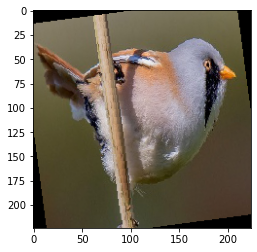

In [9]:
img = imgs[0]
img_permute = img.permute(1, 2, 0)
img_permute = 0.5 * img_permute + 0.5
img_permute = np.clip(img_permute, 0, 1)
plt.imshow(img_permute)

## モデルの構築

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=28 * 28 * 128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
cnn = CNN(275)
cnn.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=100352, out_features=275, bias=True)
)

## 学習・検証

過学習を抑制するために、学習率を変更してみる。

weight_decayで正則化を行うことも可能

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=5e-4)

In [13]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = cnn(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = cnn(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc +=torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print('epoch: {}, loss: {}, acc: {},\t val_loss: {}, val_acc: {}'.format(
        epoch, running_loss, running_acc, val_running_loss, val_running_acc))

C:\Users\lear0\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, loss: 5.322981643172988, acc: 0.03380231559276581,	 val_loss: 4.652457736259283, val_acc: 0.09447674453258514
epoch: 1, loss: 4.179616861108937, acc: 0.16433867812156677,	 val_loss: 3.270434407300727, val_acc: 0.2996124029159546
epoch: 2, loss: 3.2603692266331703, acc: 0.3106206953525543,	 val_loss: 2.6295315692591115, val_acc: 0.4102228581905365
epoch: 3, loss: 2.7824811338167375, acc: 0.40080252289772034,	 val_loss: 2.4444305065066314, val_acc: 0.4489341080188751
epoch: 4, loss: 2.5145112544189185, acc: 0.44356968998908997,	 val_loss: 2.263504126044207, val_acc: 0.47848838567733765
epoch: 5, loss: 2.351569431116793, acc: 0.47648313641548157,	 val_loss: 2.1124267120694005, val_acc: 0.5060561895370483
epoch: 6, loss: 2.21948121936764, acc: 0.5016253590583801,	 val_loss: 2.0455989837646484, val_acc: 0.5352712869644165
epoch: 7, loss: 2.10468537208754, acc: 0.5231105089187622,	 val_loss: 2.044092744588852, val_acc: 0.5423933863639832
epoch: 8, loss: 2.037720486576215, acc: 0.53

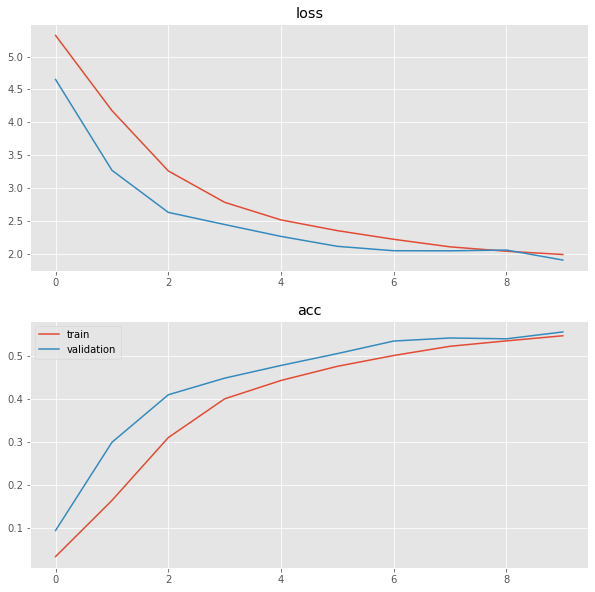

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(losses, label='train')
plt.plot(val_losses, label='validation')

plt.subplot(2, 1, 2)
plt.title('acc')
plt.plot(accs, label='train')
plt.plot(val_accs, label='validation')

plt.legend()

## まとめ
### 6/30
結果については、過学習が起こっていることが確認できる。そのため、次回は

- データ拡張を行う。
- 正則化を行う。


また、今回遭遇したトラブルは、

- ミニバッチのサイズを大きくすると、GPUがメモリ不足を起こす。
- ミニバッチのサイズと学習率の両方の考慮が必要である。

これらに気を付けて、これからも学習を続ける。

## 7/1
このモデルだと学習が厳しそうなので、次の実装でVGGを用いてみる